# LSTM Version 2.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
#tf.config.list_physical_devices()

2.11.0


## Defining functions for model training

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    # add extra dimension to 'series' for correct shape
    ds = tf.data.Dataset.from_tensor_slices(series)
    # 1D dataset
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # Shifts window 1 timestep at a time
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # Flattens nested windows into single dataset
    ds = ds.shuffle(shuffle_buffer)
    # Shuffles dataset to ensure training examples are presented in random order
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    # Applies function to each window in dataset
    return ds.batch(batch_size).prefetch(1)

In [3]:
# We can use this function to make some prediction by using the trained model 

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Preprocessing Data

In [4]:
df = pd.read_csv('../../Data/Savitzky-Golay Data/SVG_poly1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(74783, 2)


,Year,Sunspot_Number
0,1818.001,34.566570
1,1818.004,34.546053
2,1818.007,34.525535
3,1818.010,34.505017
4,1818.012,34.484499


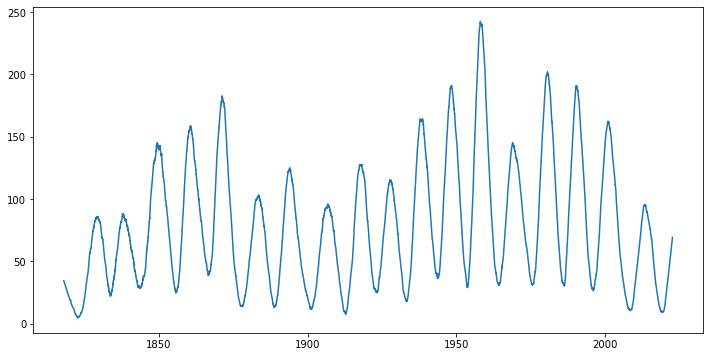

In [5]:
series = df['Sunspot_Number']
time = df['Year']

plt.figure(figsize=(12, 6))
plt.plot(time, series);

In [6]:
split_time = 65000
skips = 20
time_train = time[:split_time:skips]
y_train = series[:split_time:skips]
time_valid = time[split_time::skips]
y_valid = series[split_time::skips]

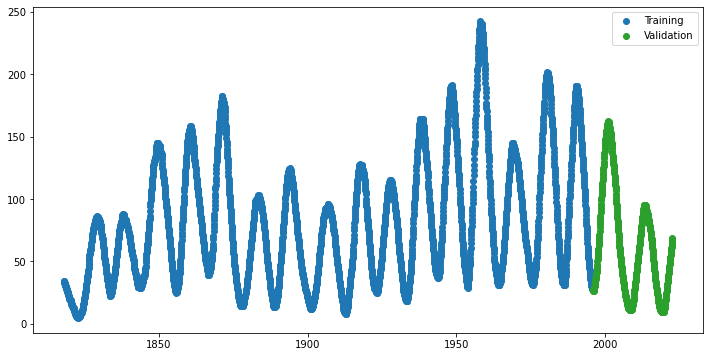

In [7]:
plt.figure(figsize=(12, 6))
plt.scatter(time_train, y_train, color='tab:blue', label='Training')
plt.scatter(time_valid, y_valid, color='tab:green', label='Validation')
plt.legend();

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 132
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)
print(y_train.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
(3250,)


## Determining the optimum learning rate

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss = tf.keras.losses.Huber()

In [10]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
49/49 [==============================] - 5s 50ms/step - loss: 152.1780 - mae: 152.6776 - lr: 1.0000e-08
Epoch 2/100
49/49 [==============================] - 2s 35ms/step - loss: 126.1076 - mae: 126.6070 - lr: 1.1220e-08
Epoch 3/100
49/49 [==============================] - 2s 38ms/step - loss: 99.9364 - mae: 100.4360 - lr: 1.2589e-08
Epoch 4/100
49/49 [==============================] - 2s 40ms/step - loss: 74.9651 - mae: 75.4646 - lr: 1.4125e-08
Epoch 5/100
49/49 [==============================] - 2s 45ms/step - loss: 55.4838 - mae: 55.9823 - lr: 1.5849e-08
Epoch 6/100
49/49 [==============================] - 2s 38ms/step - loss: 44.7597 - mae: 45.2550 - lr: 1.7783e-08
Epoch 7/100
49/49 [==============================] - 2s 38ms/step - loss: 38.7496 - mae: 39.2461 - lr: 1.9953e-08
Epoch 8/100
49/49 [==============================] - 2s 38ms/step - loss: 32.9991 - mae: 33.4958 - lr: 2.2387e-08
Epoch 9/100
49/49 [==============================] - 2s 38ms/step - loss: 30.8603 -

(1e-08, 0.001, 0.0, 80.0)

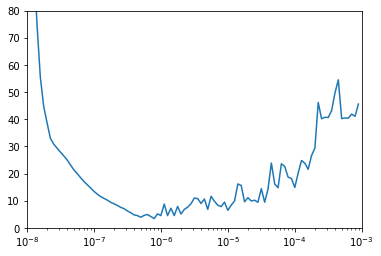

In [11]:
# Let's visualize "learning rate" vs "loss"
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 80])

In [12]:
# Let's rerun the model with the optimul learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000 
window_size = 132 # How do I choose the optimum size?
batch_size = 64

train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400) # not sure what is scaling the data
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

history = model.fit(train_set, epochs=500)

Epoch 1/500
49/49 [==============================] - 5s 38ms/step - loss: 38.0489 - mae: 38.5451
Epoch 2/500
49/49 [==============================] - 2s 32ms/step - loss: 17.2103 - mae: 17.7018
Epoch 3/500
49/49 [==============================] - 2s 33ms/step - loss: 9.7349 - mae: 10.2117
Epoch 4/500
49/49 [==============================] - 2s 33ms/step - loss: 6.6535 - mae: 7.1108
Epoch 5/500
49/49 [==============================] - 2s 32ms/step - loss: 5.7303 - mae: 6.1876
Epoch 6/500
49/49 [==============================] - 2s 32ms/step - loss: 5.1512 - mae: 5.6091
Epoch 7/500
49/49 [==============================] - 2s 33ms/step - loss: 5.3811 - mae: 5.8429
Epoch 8/500
49/49 [==============================] - 2s 32ms/step - loss: 5.8769 - mae: 6.3513
Epoch 9/500
49/49 [==============================] - 2s 32ms/step - loss: 5.7253 - mae: 6.2035
Epoch 10/500
49/49 [==============================] - 2s 33ms/step - loss: 4.9906 - mae: 5.4581
Epoch 11/500
49/49 [========================

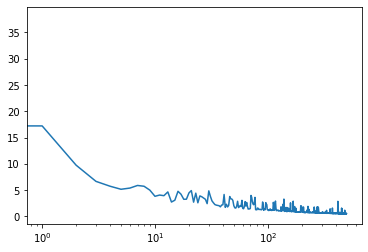

In [13]:
plt.semilogx(history.history["loss"]);

In [14]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

<ipython-input-14-758da175dde7>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)


2333/2333 [==============================] - 35s 15ms/step


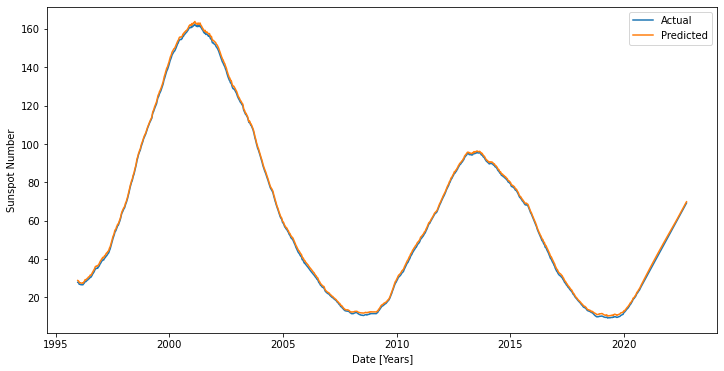

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(time[split_time:], series[split_time:], label='Actual')
plt.plot(time[split_time:], rnn_forecast, label='Predicted')
plt.xlabel('Date [Years]')
plt.ylabel('Sunspot Number')
plt.legend();

#### Comment on plot:

This prediction is **outstanding**! The NN architecture seems to be able to predict the exact shape of the two solar cycles.

In [26]:
# Standard Deviation
std = np.std(series[split_time:] - rnn_forecast) # std
std2 = np.std(series[split_time:])
normalised_std = np.array(std / np.mean(series[split_time:]))
normalised_std2 = np.array(std2 / np.mean(series[split_time:]))

# Correlation
correlation = np.array(np.corrcoef(series[split_time:], rnn_forecast)[0, 1])

print(f'The normalised standard deviation is {normalised_std:.3f}, and the correlation is {correlation:.3f}.')

The normalised standard deviation is 0.004, and the correlation is 1.000.
